<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture Series by Dr. Adrian Oeftiger</h2>

<h3 style="text-align: center; vertical-align: middle; margin-top: 1em; margin-bottom: 1em;">Guest Lecture by Dr. Andrea Santamaria Garcia</h3>

<div style="width: 45%; margin: auto; vertical-align: middle; ">
<img src="./img/etit.png" style="width: 40%; float: left; vertical-align: center" /><img src="./img/KIT_logo.svg" style="width: 38%; float: right; vertical-align: center;" />
</div>
<div style="clear: both; vertical-align: middle;"></div>

<h3 style="text-align: center; vertical-align: middle; ">Part 14: 10.02.2023</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-14/v1.0"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-14/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-14).

<h2>Run this first!</h2>

Imports and modules:

In [ ]:
from config import (np, plt)
from scipy.constants import m_p, e, c
%matplotlib inline

<h2 style="color: #b51f2a">Refresher!</h2>

- ...

<h2 style="color: #b51f2a">Today!</h2>

1. Bayesian Optimisation
2. XYZ

<div style="text-align: center; width:100%;">
    <h2>Part I: Bayesian Optimisation</h2>
</div>

<h2>Hit Me!</h2>

(...)

<p style="color: #e6541a;">$\implies$ play with the value XY and try out ABC! (Exercise for the students to change some cells)</p>

<h2>An Image</h2>

<img src="img/some-image.png" alt="what's inside the image" style="width: 80%; margin: auto;" />

<p style="clear: both; font-size: 10pt; text-align: right; float: right;">image by <a href="https://google.me/">XYZ</a></p>

<h2>Something</h2>

(...)

<h2>Summary</h2>

- ... all contents as relevant for the exam

<h2>Literature</h2>

In [319]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
from botorch.models import SingleTaskGP
import numpy as np
import botorch
import gpytorch
import torch
from matplotlib import pyplot as plt
from typing import Union, Optional
import warnings
warnings.filterwarnings('ignore')

## Refresher: Gaussian Process

First, let's define a test function

$$ y = \sin (2 \pi x) + \epsilon$$

In [350]:
# Set Random seed for reproducibility
random_seed = 1
rng = torch.random.manual_seed(random_seed)

# Setup our test function
train_x = torch.linspace(0,1,15).reshape(-1,1)
train_y = (torch.sin(train_x * 2 * np.pi) + torch.randn(size=train_x.size(), generator=rng) * 0.2).reshape(-1,1)
fine_x = torch.linspace(0,1,200).reshape(-1,1)
fine_y = torch.sin(fine_x * 2 * np.pi)
test_X = torch.linspace(0,1,200)

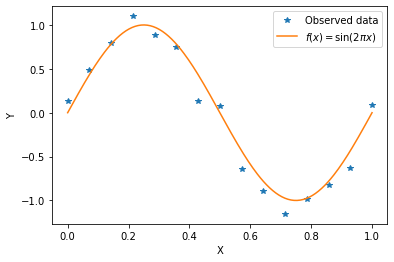

In [351]:
plt.plot(train_x, train_y, "*", label="Observed data")
plt.plot(fine_x, fine_y, label=r"$f(x)=\sin(2\pi x)$")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

### TODO: Clean-up the plotting utils and imports to seperate function

In [353]:
def sample_gp_prior_plot(model: Union[ExactGP,SingleTaskGP], n_samples: int=5, ax=None, y_lim: Optional[tuple]=None):
    with gpytorch.settings.prior_mode(True):
        model.eval()
        preds = model(test_X)

    # Plotting
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    prior_mean = preds.mean.detach().numpy()
    prior_std = preds.stddev.detach().numpy()
    ax.plot(test_X, prior_mean)
    ax.fill_between(test_X, prior_mean-2*prior_std, prior_mean+2*prior_std, alpha=0.2)
    for i in range(n_samples):
        y_sample = preds.sample();
        ax.plot(test_X, y_sample,ls=":")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Samples drawn from the prior GP model")
    if y_lim is not None:
        ax.set_ylim(y_lim)
    return ax

In [361]:
def sample_gp_posterior_plot(model: Union[ExactGP,SingleTaskGP], n_samples: int=5, ax=None, y_lim: Optional[tuple]=None):
    with gpytorch.settings.prior_mode(False):
        model.eval()
        preds = model(test_X)

    # Plotting
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    prior_mean = preds.mean.detach().numpy()
    prior_std = preds.stddev.detach().numpy()
    ax.plot(test_X, prior_mean,label="GP mean")
    ax.fill_between(test_X, prior_mean-2*prior_std, prior_mean+2*prior_std, alpha=0.2, label=r"2$\sigma$ confidence bound")
    for i in range(n_samples):
        y_sample = preds.sample();
        ax.plot(test_X, y_sample,ls=":")
    # Add observed data
    ax.plot(model.train_inputs[0].flatten(), model.train_targets, color='black', ls="", marker="*",label='Data points')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("GP Posterior")
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.legend()
    return ax

In [362]:
kernel = ScaleKernel(RBFKernel())
model = SingleTaskGP(train_X=train_x, train_Y=train_y, covar_module=kernel)
model.covar_module.base_kernel.lengthscale = 0.2
model.covar_module.outputscale = 1
model.likelihood.noise_covar.noise = 0.1

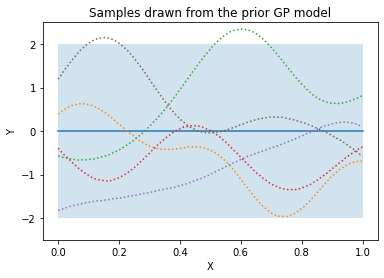

In [363]:
ax = sample_gp_prior_plot(model)
ax.set_ylim(-2.5,2.5);

<AxesSubplot:title={'center':'GP Posterior'}, xlabel='X', ylabel='Y'>

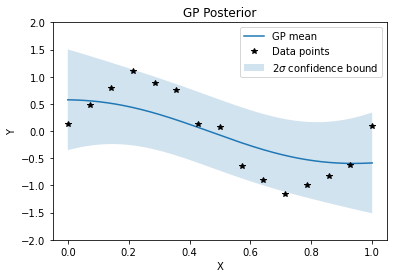

In [364]:
kernel = ScaleKernel(RBFKernel())
model = SingleTaskGP(train_X=train_x, train_Y=train_y, covar_module=kernel)
#################################################################################
### Modify the values below so that GP model properly fits the unknown function
model.covar_module.base_kernel.lengthscale = 0.5
model.covar_module.outputscale = 1
model.likelihood.noise_covar.noise = 1
#################################################################################

# Show the GP posterior with observed data points
sample_gp_posterior_plot(model, y_lim=(-2,2), n_samples=0)

# You can now increase the n_samples to show some functions sampled from the GP posterior

<div style="text-align: center; width:100%;">
    <h2>Part II: BO for Beam Positioning and Focusing at Linac</h2>
</div>

In [2]:
from ares_ea.env import ARESEA
from gym.wrappers import RescaleAction

In [3]:
# Create a Gym Env

env = ARESEA()

# Wrap the environment with some utilities:

env = RescaleAction(env, -1, 1)  # Normalize the action space to [-1,1]^n

### Exercise: Apply some manual actions to move the beam

action = np.array([])  # put your action here
observation, reward, done, info = env.step(action)  # Perform one step: update the env, observe new beam!
